In [2]:
import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from tqdm import tqdm
from hashlib import md5

In [3]:
PATH = 'data/notMNIST_large'
CLASSES = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

dataset = {}
for root, dirs, files in os.walk(PATH):
    for subdir in tqdm(dirs):
        dataset[subdir] = os.listdir(os.path.join(root, subdir))
        

100%|██████████████████████████████████████████| 10/10 [12:50<00:00, 77.00s/it]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


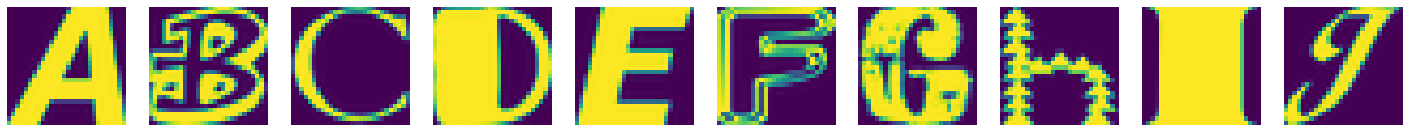

In [8]:
# Задание 1.
# Загрузите данные и отобразите на экране несколько
# из изображений с помощью языка Python

fig, axs = plt.subplots(1, len(CLASSES), figsize=(25, 25))
axs = axs.ravel()

for i in range(len(CLASSES)):
    axis = axs[i]
    class_name = CLASSES[i]
    file_list = dataset[class_name]
    file_index = random.randint(0, len(file_list) - 1)
    file_name = file_list[file_index]
    img = cv2.imread(os.path.join(PATH, class_name, file_name), cv2.IMREAD_GRAYSCALE)
    axis.axis('off')
    axis.imshow(img)
    

In [9]:
# Задание 2.
# Проверьте, что классы являются сбалансированными, 
# т.е. количество изображений, принадлежащих каждому из классов, 
# примерно одинаково (В данной задаче 10 классов).

count_list = []
for class_name in dataset:
    count_list.append(len(dataset[class_name]))

print(min(count_list))
print(max(count_list))

52911
52912


In [11]:
# Задание 3.
# Разделите данные на три подвыборки: обучающую (200 тыс. изображений),
# валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений)

TRAIN_SIZE = int(200000 / len(CLASSES))
VALIDATION_SIZE = int(10000 / len(CLASSES))
TEST_SIZE = int(19000 / len(CLASSES))

train_data = {}
validation_data = {}
test_data = {}

for i in range(len(CLASSES)):
    key = CLASSES[i]
    class_list = dataset[key]
    random.shuffle(class_list)
    train_data[i] = class_list[:TRAIN_SIZE]
    validation_range = TRAIN_SIZE + VALIDATION_SIZE
    test_range = validation_range + TEST_SIZE
    validation_data[i] = class_list[TRAIN_SIZE:validation_range]
    test_data[i] = class_list[validation_range:test_range]  

In [18]:
# Задание 4. 
# Проверьте, что данные из обучающей выборки не пересекаются
# с данными из валидационной и контрольной выборок.
# Другими словами, избавьтесь от дубликатов в обучающей выборке.

def getImageHash(file_name, subdir):
    hash_md5 = md5()
    path = os.path.join(PATH, subdir, file_name)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def removeDuplicates(dataset, valid_set, test_set, subdir):
    duplicates = 0
    hash_keys = {}
    result = {}
    for file_name in valid_set + test_set:
        file_hash = getImageHash(file_name, subdir)
        if file_hash not in hash_keys:
            hash_keys[file_hash] = file_name
    
    for file_name in dataset:
        file_hash = getImageHash(file_name, subdir)
        if file_hash not in hash_keys and file_hash not in result:
            result[file_hash] = file_name
        else:
            duplicates += 1
            
    print('duplicates in ' + subdir + ' deleted: ' + str(duplicates))
    return list(result.values())

for i in tqdm(range(len(CLASSES))):
    train_data[i] = removeDuplicates(train_data[i], validation_data[i], test_data[i], CLASSES[i])

 10%|████▎                                      | 1/10 [00:55<08:18, 55.34s/it]

duplicates in A deleted: 1231


 20%|████████▌                                  | 2/10 [02:55<09:58, 74.78s/it]

duplicates in B deleted: 1211


 30%|████████████▉                              | 3/10 [03:53<08:08, 69.84s/it]

duplicates in C deleted: 1294


 40%|█████████████████▏                         | 4/10 [05:15<07:20, 73.35s/it]

duplicates in D deleted: 1337


 50%|█████████████████████▌                     | 5/10 [06:24<06:00, 72.13s/it]

duplicates in E deleted: 1254


 60%|█████████████████████████▊                 | 6/10 [07:24<04:33, 68.47s/it]

duplicates in F deleted: 1324


 70%|██████████████████████████████             | 7/10 [09:10<03:59, 79.81s/it]

duplicates in G deleted: 1225


 80%|██████████████████████████████████▍        | 8/10 [10:21<02:34, 77.06s/it]

duplicates in H deleted: 1454


 90%|██████████████████████████████████████▋    | 9/10 [11:03<01:06, 66.59s/it]

duplicates in I deleted: 3526


100%|██████████████████████████████████████████| 10/10 [11:41<00:00, 70.17s/it]

duplicates in J deleted: 1346


In [20]:
# Задание 5.
# Постройте простейший классификатор (например, с помощью логистической регрессии).
# Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000). 
# Для построения классификатора можете использовать библиотеку SkLearn (http://scikit-learn.org).

IMG_WIDTH = 28
IMG_HEIGHT = 28

def convertToLearnData(dataset):
    missing_images = 0
    y = np.zeros(0)
    x = np.zeros(0)

    for key in tqdm(dataset):
        for file_name in dataset[key]:
            img = cv2.imread(os.path.join(PATH, CLASSES[key], file_name), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
                img = img.reshape(1, IMG_WIDTH * IMG_HEIGHT)
                if len(x) > 0 and len(y) > 0:
                    x = np.append(x, img, axis=0)
                    y = np.append(y, key)
                else:
                    x = img
                    y = np.array([key])
            else:
                print("Can't load file " + file_name)
                missing_images += 1
    return x, y

trainX, trainY = convertToLearnData(train_data)
print("Train:", trainX.shape, trainY.shape)

validationX, validationY = convertToLearnData(validation_data)
print("Validation:", validationX.shape, validationY.shape)

testX, testY = convertToLearnData(test_data)
print("Test:", testX.shape, testY.shape)

  0%|                                                   | 0/10 [00:00<?, ?it/s]

Can't load file RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
Can't load file SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png


 10%|████▏                                     | 1/10 [02:34<23:07, 154.19s/it]

Can't load file TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png


100%|██████████████████████████████████████| 10/10 [3:18:50<00:00, 1193.09s/it]


Train: (184795, 784) (184795,)


  0%|                                                   | 0/10 [00:00<?, ?it/s]

Validation: (10000, 784) (10000,)


100%|██████████████████████████████████████████| 10/10 [07:02<00:00, 42.30s/it]

Test: (19000, 784) (19000,)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

TRAIN_SIZES = [5, 10, 100, 5000]

valid_scores = []
test_scores = []
for train_size in TRAIN_SIZES:
    newData = {}
    for key in train_data:
        newData[key] = train_data[key][:train_size]
    newTrainX, newTrainY = convertToLearnData(newData)
        
    model = LogisticRegression(random_state=0, max_iter=1000).fit(newTrainX, newTrainY)
    valid_scores.append(model.score(validationX, validationY))
    test_scores.append(model.score(testX, testY))

  0%|                                                   | 0/10 [00:00<?, ?it/s]

Can't load file RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png


100%|███████████████████████████████████████| 10/10 [1:26:02<00:00, 516.28s/it]


In [48]:
valid_scores

[0.5935, 0.6602, 0.7528, 0.7993]